In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from chitaxi.datasets import loader, builder

# %config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

In [2]:
loader.list_feathers()

2015_features.feather
clean_2015.feather
clean_2016.feather
data_2016.feather


# Chitaxi 02 - Features Generators

## Get Labels

In this analysis, we are going to use the information per `taxi_id` in 2015 to predict its aggregated future cash flows in 2016. Thus, our label will simply be the aggregated `trip_total` per taxi in 2016. 

> The outliers have been removed from Outlier section

In [3]:
df_2016 = loader.read_feather('clean_2016.feather')

C:\Users\l5453\Anaconda3\envs\chitaxi\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
bd = builder.Builder()
Y = bd.extract_y(df_2016)

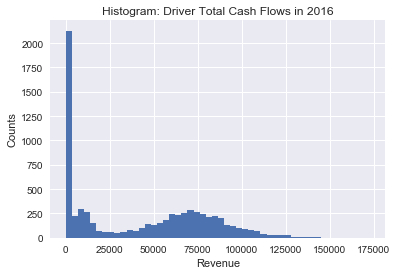

In [5]:
fig, ax = plt.subplots(1,1)
Y.hist(bins=50, ax=ax)
ax.set_xlabel('Revenue')
ax.set_ylabel('Counts')
t = ax.set_title("Histogram: Driver Total Cash Flows in 2016")

In [7]:
loader.save_as_feather(Y.reset_index(), "labels_2016.feather")

## Extract Features from time-series transactions

The general idea in this section is to aggregate and flatten the transaction level data into metrics at the monthly level. We are going to cover metrics such as total revenues per months, total trips per months, etc. to something more complicated such as workdays/holidays revenues, daytime/nighttime revenues, etc.

In [3]:
# We are using the dataset we have cleaned from the last outliers notebook
df_2015 = loader.read_feather('clean_2015.feather')

C:\Users\l5453\Anaconda3\envs\chitaxi\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


### Pre-Processing: Workdays and Holidays Split

* **workday=1**, Mon-Fri and other dates that are not holidays, 
* **daytime=1** start time from 6am to 7pm

In [302]:
fe = builder.FeatureExtraction()

In [117]:
df_2015 = fe.assign_workdays(df_2015, start='20150101', end='20151231', speed=True)
df_2015 = fe.assign_daytime(df_2015, night_end=6, night_start=19)

In [17]:
df_2015.head(10)[['taxi_id', 'trip_start_timestamp', 'workday', 'daytime']]

,taxi_id,trip_start_timestamp,workday,daytime
0,0,2015-09-15 07:30:00,1,1
1,0,2015-05-20 13:15:00,1,1
2,0,2015-08-03 13:15:00,1,1
3,0,2015-05-07 19:45:00,1,0
4,0,2015-09-28 03:45:00,1,0
5,0,2015-05-12 19:00:00,1,0
6,0,2015-10-02 10:45:00,1,1
7,0,2015-01-05 22:45:00,1,0
8,0,2015-02-07 01:30:00,0,0
9,0,2015-04-28 09:45:00,1,1


### Monthly Aggregations

### 1. Trip Counts Per Month

Aggregate the total number of trips per months per driver.

In [666]:
# fe.set_resample(df_2015, 'm')
groupby = fe.GROUP_BY

In [667]:
fe = builder.FeatureExtraction()
fe.GROUP_BY = groupby

In [307]:
taxi_count = fe.get_trip_counts()

In [665]:
taxi_count.head(3)

,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12
taxi_id,,,,,,,,,,,,
0,298.0,467.0,461.0,462.0,476.0,1064.0,587.0,667.0,645.0,778.0,619.0,601.0
2,635.0,382.0,469.0,517.0,352.0,598.0,382.0,765.0,169.0,0.0,0.0,0.0
3,445.0,474.0,609.0,526.0,497.0,533.0,560.0,511.0,504.0,560.0,470.0,370.0


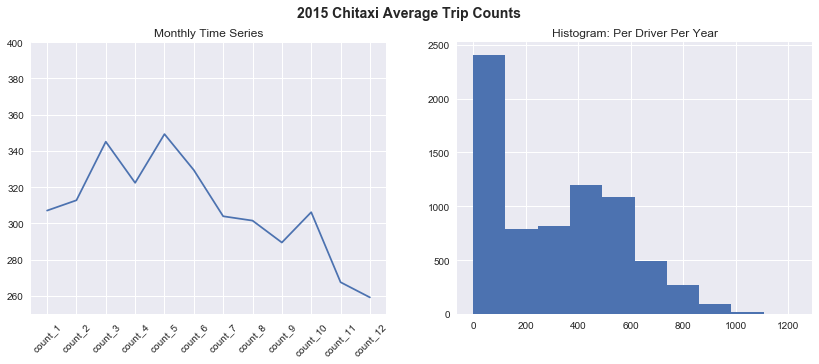

In [376]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

taxi_count.mean(axis=0).plot(ylim=(250,400), ax=ax[0], xticks=np.arange(12), rot=45, title='Monthly Time Series')
taxi_count.mean(axis=1).hist(ax=ax[1])
ax[1].set_title('Histogram: Per Driver Per Year')
t = fig.suptitle('2015 Chitaxi Average Trip Counts', fontsize=14, fontweight=700)

We noticed the general trend of trips seems declining over year. This might be caused partially by the seasonality and influenced by the harder and harder competition with companies such as Uber and Lyft. 

Reference: https://www.usatoday.com/story/news/2017/06/05/chicago-cabbies-say-industry-teetering-toward-collapse/102524634/

### 2. Trip Total Per Month

Similar to the counts of trips, we also aggregate the `trip_total` which would be the total revenue per month per driver.

Then trend is aligned with what we discovered before. The histogram indicates that the distribution is also close to 2016's. While most taxies had around 7K per month, we also observed a large volume of small revenues around 0.

In [309]:
taxi_sum = fe.get_trip_total()

In [663]:
taxi_sum.head(3)

,total_sum_1,total_sum_2,total_sum_3,total_sum_4,total_sum_5,total_sum_6,total_sum_7,total_sum_8,total_sum_9,total_sum_10,total_sum_11,total_sum_12
taxi_id,,,,,,,,,,,,
0,5194.07,8397.45,8278.91,7619.70,8336.38,11919.99,7111.31,8156.02,10838.18,12135.44,8947.49,6830.32
2,7003.05,4319.82,5682.80,6071.85,4105.73,7536.61,4645.43,8027.02,1840.01,0.00,0.00,0.00
3,7057.64,6978.48,7944.19,7990.65,8039.19,8295.23,7946.26,7541.35,7370.00,7962.35,6929.20,5280.95


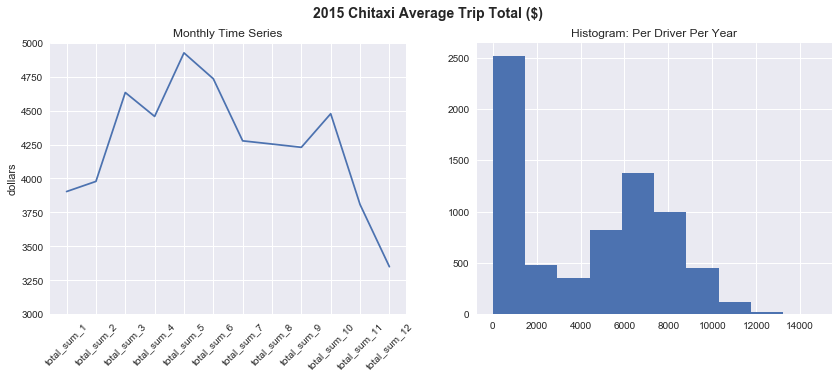

In [375]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

taxi_sum.mean(axis=0).plot(ylim=(3000,5000), ax=ax[0], xticks=np.arange(12), rot=45, title='Monthly Time Series')
taxi_sum.mean(axis=1).hist(ax=ax[1])
ax[1].set_title('Histogram: Per Driver Per Year')
ax[0].set_ylabel('dollars')
t = fig.suptitle('2015 Chitaxi Average Trip Total ($)', fontsize=14, fontweight=700)

### 3. Trip Miles and Seconds

The miles and trip seconds (time) are relative more noisy than other monetary metrics. While we cleaning data, we noticed there are a lot transactions that have mismatched miles and seconds. (Very long trip with almost no driving time or very long driving time without trip miles)

By removing those outstanding outliers, we have their distributions as below:

In [669]:
taxi_miles = fe.get_trip_miles()

In [670]:
taxi_seconds = fe.get_trip_seconds()

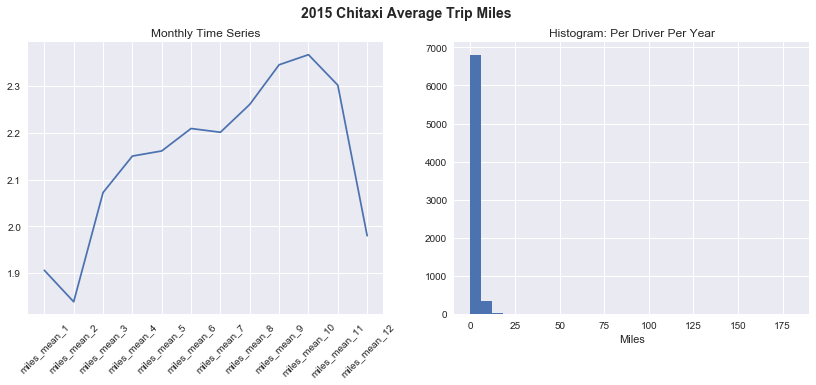

In [677]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

taxi_miles.mean(axis=0).plot(ax=ax[0], xticks=np.arange(12), rot=45, title='Monthly Time Series')
taxi_miles.mean(axis=1).hist(ax=ax[1],bins=30)
ax[1].set_title('Histogram: Per Driver Per Year')
ax[1].set_xlabel('Miles')
t = fig.suptitle('2015 Chitaxi Average Trip Miles', fontsize=14, fontweight=700)

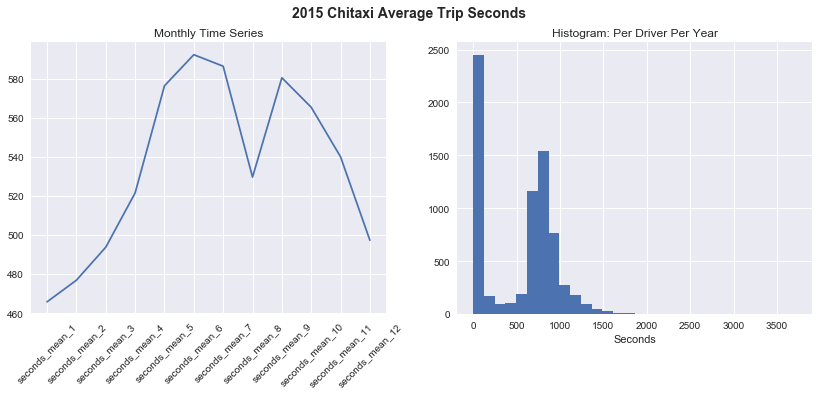

In [678]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

taxi_seconds.mean(axis=0).plot(ax=ax[0], xticks=np.arange(12), rot=45, title='Monthly Time Series')
taxi_seconds.mean(axis=1).hist(ax=ax[1],bins=30)
ax[1].set_title('Histogram: Per Driver Per Year')
ax[1].set_xlabel('Seconds')
t = fig.suptitle('2015 Chitaxi Average Trip Seconds', fontsize=14, fontweight=700)

### 4. Workday vs. Holidays&Weekends trip_total percentage

We are expecting taxies should have more revenues over workdays instead of holidays/weekends, simply because we have more workdays in a calendar year. 

The empirical finding shows we have around 0.35:0.65 ratio towards per taxi's workday/holiday revenues.

In [311]:
taxi_workday = fe.get_workday_ratio(df_2015, 'm')

In [662]:
taxi_workday.head(3)

,total_workday0_1,total_workday1_1,total_workday0_2,total_workday1_2,total_workday0_3,total_workday1_3,total_workday0_4,total_workday1_4,total_workday0_5,total_workday1_5,...,total_workday0_8,total_workday1_8,total_workday0_9,total_workday1_9,total_workday0_10,total_workday1_10,total_workday0_11,total_workday1_11,total_workday0_12,total_workday1_12
taxi_id,,,,,,,,,,,,,,,,,,,,,
0,0.373343,0.626657,0.293112,0.706888,0.304491,0.695509,0.240146,0.759854,0.372947,0.627053,...,0.281634,0.718366,0.246722,0.753278,0.274600,0.725400,0.317475,0.682525,0.264856,0.735144
2,0.405899,0.594101,0.388433,0.611567,0.348705,0.651295,0.290809,0.709191,0.493586,0.506414,...,0.318806,0.681194,0.340216,0.659784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.340192,0.659808,0.339264,0.660736,0.269043,0.730957,0.292378,0.707622,0.383141,0.616859,...,0.355419,0.644581,0.315233,0.684767,0.348511,0.651489,0.373050,0.626950,0.284856,0.715144


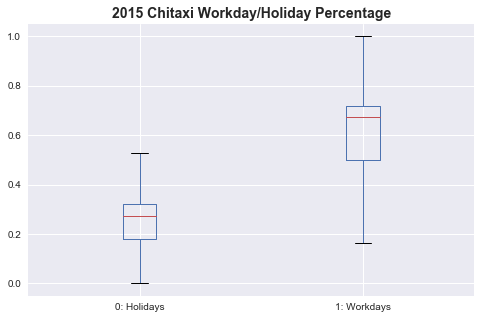

In [312]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

pd.DataFrame({
    '0: Holidays': taxi_workday.iloc[:, [i for i in range(0, 24, 2)]].mean(axis=1),
    '1: Workdays': taxi_workday.iloc[:, [i for i in range(1, 25, 2)]].mean(axis=1)
}).plot.box(ax=ax)
t = ax.set_title("2015 Chitaxi Workday/Holiday Percentage", fontsize=14, fontweight=700)

### 5.  Daytime/non-daytime trip_total percentage

We are also expecting the daytime revenue should be slightly higher than the nighttime revenue. The empirical findings show that these two ratios are very close to each other. In addition, their distribution is more "scattered". We have some taxies mainly serve in night or day.

In [313]:
taxi_daytime = fe.get_daytime_ratio(df_2015, 'm')

In [661]:
taxi_daytime.head(3)

,total_daytime0_1,total_daytime1_1,total_daytime0_2,total_daytime1_2,total_daytime0_3,total_daytime1_3,total_daytime0_4,total_daytime1_4,total_daytime0_5,total_daytime1_5,...,total_daytime0_8,total_daytime1_8,total_daytime0_9,total_daytime1_9,total_daytime0_10,total_daytime1_10,total_daytime0_11,total_daytime1_11,total_daytime0_12,total_daytime1_12
taxi_id,,,,,,,,,,,,,,,,,,,,,
0,0.847740,0.152260,0.474505,0.525495,0.506818,0.493182,0.516309,0.483691,0.499491,0.500509,...,0.273967,0.726033,0.449359,0.550641,0.507747,0.492253,0.624005,0.375995,0.379373,0.620627
2,0.373956,0.626044,0.423305,0.576695,0.527627,0.472373,0.564186,0.435814,0.814381,0.185619,...,0.208260,0.791740,0.247689,0.752311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.484027,0.515973,0.450131,0.549869,0.481646,0.518354,0.434523,0.565477,0.466093,0.533907,...,0.430890,0.569110,0.394315,0.605685,0.465341,0.534659,0.465083,0.534917,0.443106,0.556894


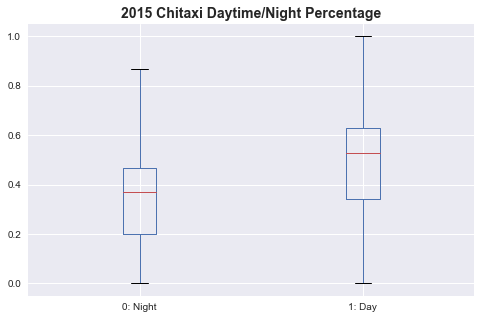

In [314]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

pd.DataFrame({
    '0: Night': taxi_daytime.iloc[:, [i for i in range(0, 24, 2)]].mean(axis=1),
    '1: Day': taxi_daytime.iloc[:, [i for i in range(1, 25, 2)]].mean(axis=1)
}).plot.box(ax=ax)

t = ax.set_title("2015 Chitaxi Daytime/Night Percentage", fontsize=14, fontweight=700)

### 6. Quantiles of trip totals

In this section, we also pulled quantiles (25%, 50%, 75%) from trips per driver per month, in the hope to capture more accurate shape of revenue flows when flattening the data from transaction level to monthly level.

* The mean is higher than the median, influenced more by the high value trips.
* Higher quantiles trips tend to be more volatile over months.
* We observed similar drawdown in 75% quantiles, which is aligned with the total trips shape. It seems like they contribute more to the overall revenue's trends.

In [315]:
taxi_q = fe.get_quantiles()

In [660]:
taxi_q.head(3)

,total_25p_1,total_25p_2,total_25p_3,total_25p_4,total_25p_5,total_25p_6,total_25p_7,total_25p_8,total_25p_9,total_25p_10,...,total_mean_3,total_mean_4,total_mean_5,total_mean_6,total_mean_7,total_mean_8,total_mean_9,total_mean_10,total_mean_11,total_mean_12
taxi_id,,,,,,,,,,,,,,,,,,,,,
0,7.25,7.250,7.45,7.05,7.45,6.625,7.0500,6.65,6.9900,7.05,...,17.958590,16.492857,17.513403,11.202998,12.114668,12.227916,16.803380,15.598252,14.454750,11.364925
2,6.40,6.775,6.85,7.05,7.05,7.150,7.4525,6.75,7.2500,0.00,...,12.116844,11.744391,11.664006,12.603027,12.160812,10.492837,10.887633,0.000000,0.000000,0.000000
3,7.05,6.650,6.65,6.85,7.25,7.250,7.4500,7.25,7.0725,7.45,...,13.044647,15.191350,16.175433,15.563283,14.189750,14.758023,14.623016,14.218482,14.742979,14.272838


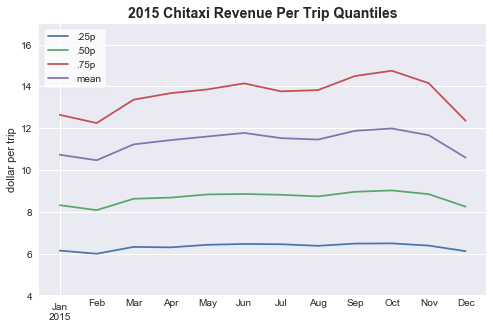

In [373]:
import datetime

fig, ax = plt.subplots(1,1,figsize=(8,5))

pd.DataFrame({
    '.25p': taxi_q.iloc[:,:12].mean(axis=0).values,
    '.50p': taxi_q.iloc[:,12:24].mean(axis=0).values,
    '.75p': taxi_q.iloc[:,24:36].mean(axis=0).values,
    'mean': taxi_q.iloc[:,36:].mean(axis=0).values,
},index=pd.date_range(start='2015-01-01', end='2015-12-31', freq='M')).plot(ax=ax, ylim=(4, 17))

ax.set_ylabel('dollar per trip')
t = ax.set_title('2015 Chitaxi Revenue Per Trip Quantiles', fontsize=14, fontweight=700)

### 7. Maximum / Avg Trip Breaks

In some web application's user behaviour analysis, it's important to look at users' `TIME_BETWEEN_SESSIONS` to predict if a user is a heavy user. 

Applying the similar idea, we calculated each taxi's average and maximum `TIME_BETWEEN_TRIPS` at hourly level.

We made following assumptions to make the calculation easier:
* If a taxi has only one trip in a month, we simply take it's maximum/average `TIME_BETWEEN_TRIPS` as half a month.
* If a taxi has no trip at all in a month, we simply use 30 days to count its `TIME_BETWEEN_TRIPS`
* We are using the time-difference between `trip_start_time` as `TIME_BETWEEN_TRIPS`, it will be more accurate to use `start_time` - `end_time`. (It may also be challenging as some trips have wrong/incorrect/missing `end_time` metric.

Empirically, we observed most taxies are working frequently per month, with average `TIME_BETWEEN_TRIPS` less than 100 hours. On the other side tail, there are some taxis almost stopped running for more than half year.

In [631]:
taxi_hrs = fe.get_break_hours(df_2015, 'm')

In [659]:
taxi_hrs.head(3)

,max_break_hrs_1,max_break_hrs_2,max_break_hrs_3,max_break_hrs_4,max_break_hrs_5,max_break_hrs_6,max_break_hrs_7,max_break_hrs_8,max_break_hrs_9,max_break_hrs_10,...,avg_break_hrs_3,avg_break_hrs_4,avg_break_hrs_5,avg_break_hrs_6,avg_break_hrs_7,avg_break_hrs_8,avg_break_hrs_9,avg_break_hrs_10,avg_break_hrs_11,avg_break_hrs_12
taxi_id,,,,,,,,,,,,,,,,,,,,,
0,40.0,23.0,33.0,42.0,68.0,14.0,168.0,48.0,70.0,14.0,...,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0
2,20.0,49.0,35.0,23.0,24.0,18.0,73.0,39.0,37.0,720.0,...,3.0,2.0,4.0,2.0,3.0,2.0,3.0,720.0,720.0,720.0
3,40.0,48.0,57.0,19.0,42.0,19.0,23.0,22.0,19.0,22.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0


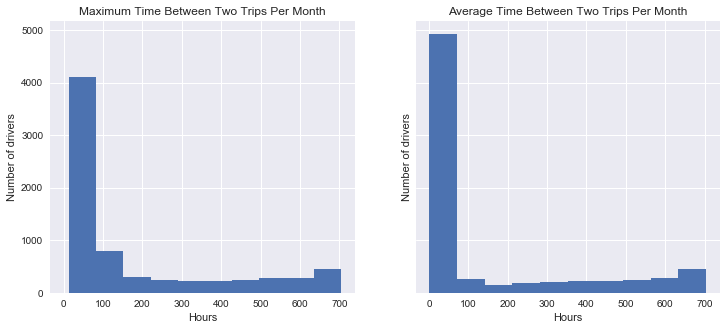

In [655]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

taxi_hrs.iloc[:,:12].mean(axis=1).hist(ax=ax[0])
ax[0].set_title("Maximum Time Between Two Trips Per Month")
taxi_hrs.iloc[:,12:].mean(axis=1).hist(ax=ax[1])
ax[1].set_title("Average Time Between Two Trips Per Month")
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Number of drivers')
ax[1].set_xlabel('Hours')
t=ax[1].set_ylabel('Number of drivers')

## Merge All Features together

In this section we simply wrap up what we have so far:

* We have 7155 unique taxi in 2015
* By aggregating metrics into months, we have 168 numerical features per taxi


## Improvements:

* We haven't used the `geo-coding` yet, potentially the locations at each trip's start point can give us more information regarding taxi's "working area".

In [679]:
features = [
    taxi_count,
    taxi_daytime,
    taxi_hrs,
    taxi_miles,
    taxi_q,
    taxi_seconds,
    taxi_sum,
    taxi_workday
]

from functools import reduce
feature_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='outer'), features)

In [705]:
# Check if any feature contains null values
feature_final.columns[feature_final.isna().sum() > 0]

Index([], dtype='object')

In [704]:
feature_final.shape

(7155, 168)

After a quick check, we have 7155 unique `taxi_id` in 2015, with 168 features. More investigations will be conducted in the following feature engineering section.

In [711]:
feature_final.head(3)

,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,...,total_workday0_8,total_workday1_8,total_workday0_9,total_workday1_9,total_workday0_10,total_workday1_10,total_workday0_11,total_workday1_11,total_workday0_12,total_workday1_12
taxi_id,,,,,,,,,,,,,,,,,,,,,
0,298.0,467.0,461.0,462.0,476.0,1064.0,587.0,667.0,645.0,778.0,...,0.281634,0.718366,0.246722,0.753278,0.274600,0.725400,0.317475,0.682525,0.264856,0.735144
2,635.0,382.0,469.0,517.0,352.0,598.0,382.0,765.0,169.0,0.0,...,0.318806,0.681194,0.340216,0.659784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,445.0,474.0,609.0,526.0,497.0,533.0,560.0,511.0,504.0,560.0,...,0.355419,0.644581,0.315233,0.684767,0.348511,0.651489,0.373050,0.626950,0.284856,0.715144


In [714]:
# feature_final.to_csv("features_2015.csv", index=True)
loader.save_as_feather(feature_final.reset_index(), '2015_features.feather')